# Imports:

In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [20]:
import mne
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from mne.decoding import CSP
from sklearn.metrics import classification_report, confusion_matrix
import copy
import sys, os
import pandas as pd
import time
from scipy import signal
import scipy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#import torch
#from torch import nn
from sklearn.metrics import classification_report
from contextlib import redirect_stdout, redirect_stderr
import io
import pickle
import time
import random
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from torchsummary import summary
#import torchinfo
#import moabb

# EEGNet-specific imports
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *            # Imports every needed algorithm such as CNN, RNN, LSTM, etc.
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy



# ATCNet Model imports
import models

In [4]:
# projects/def-b09sdp/bijan/Phase2/P16.fdt
path = !pwd
path

['/home/bijan/py3x/Code_Zhang/Transfer_Learning_On_EEG_BCI']

# Functions:

In [5]:
def data_wrapper(data_epochs, data_labels, mode='binary'):
    
    if mode == 'binary':
        epochs = []
        labels = []

        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            binary_epochs = participant_epochs[(participant_labels==1) | (participant_labels==2)]
            #class2_epochs = participant_epochs[participant_labels==2]
            #bi_epochs = np.concatenate((class1_epochs, class2_epochs), axis=0)
            epochs.append(binary_epochs)
    
            binary_labels = participant_labels[(participant_labels==1) | (participant_labels==2)]
            #bi_labels = np.concatenate((class1_labels, class2_labels), axis=0)
            labels.append(binary_labels)
            
    elif mode == '3_class':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==1) | (participant_labels==2) | (participant_labels==3)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==1) | (participant_labels==2) | (participant_labels==3)]
            labels.append(multiclass_labels)
            
            
    elif mode == '4_class_RS':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==2) | (participant_labels==6) | (participant_labels==5) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==2) | (participant_labels==6) | (participant_labels==5) | (participant_labels==1)]
            labels.append(multiclass_labels)
        
    elif mode == '4_class_LS':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==1)]
            labels.append(multiclass_labels)
    elif mode == '6_class':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==6) | (participant_labels==2) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==6) | (participant_labels==2) | (participant_labels==1)]
            labels.append(multiclass_labels)
    
    return epochs, labels

In [ ]:
def epoch_label_extractor(Data, epoch_length=1123, num_channels=64):
    df = Data.to_data_frame()
    X = df[df.columns[3:]].to_numpy()
    X = np.transpose(X)

    number_of_epochs = int(len(df)/epoch_length)
    
    randomlist = random.sample(range(number_of_epochs), number_of_epochs)

    data = np.zeros((number_of_epochs,num_channels, epoch_length))
    labels = np.zeros((number_of_epochs,1)).astype(int)

    for i in range(number_of_epochs):
        data[i,:,:] = X[:, randomlist[i]*epoch_length:(randomlist[i] + 1)*epoch_length]
        if (df['condition'][randomlist[i]*epoch_length] == 'Left'):
            labels[i,0] = 0
        elif(df['condition'][randomlist[i]*epoch_length] == 'Right'):
            labels[i,0] = 1
        elif(df['condition'][randomlist[i]*epoch_length] == 'Feet'):
            labels[i,0] = 2
        elif(df['condition'][randomlist[i]*epoch_length] == 'Tongue'):
            labels[i,0] = 3
        elif(df['condition'][randomlist[i]*epoch_length] == 'Mis'):
            labels[i,0] = 4
        elif(df['condition'][randomlist[i]*epoch_length] == 'Si'):
            labels[i,0] = 5
        else:
            labels[i,0] = 6
        
    return data, labels

In [ ]:
def encoder(y_data, method=OneHotEncoder):
    
    encoder = OneHotEncoder()
    encoder.fit(y_data[0].reshape(-1, 1))
    
    for i in range(len(y_data)):
        
        a = encoder.transform(y_data[i].reshape(-1, 1))
        y_data[i] = a.toarray()

    return y_data

In [22]:
def class_extraction(classes, data, labels):
    mask = np.isin(labels[:, 0], classes)
    dataset = data[mask, :, :]
    Final_labels = labels[mask, :]
    return dataset, Final_labels

In [7]:
def encoder(y_data, method=OneHotEncoder):
    
    encoder = OneHotEncoder()
    encoder.fit(y_data[0].reshape(-1, 1))
    
    for i in range(len(y_data)):
        
        a = encoder.transform(y_data[i].reshape(-1, 1))
        y_data[i] = a.toarray()

    return y_data

In [8]:
def calc_csp(x_train, y_train, x_test, n_components=16):
    
        csp = CSP(n_components)
        csp_fit = csp.fit(x_train, y_train)
        train_feat = csp_fit.transform(x_train)
        test_feat = csp_fit.transform(x_test)
        return train_feat, test_feat

In [9]:
def feature_extraction_4(train_data, train_labels, test_data, sampling_freq, n_components):

    # Why number of bands were set to 24??
    [n_epochs_train, n_split, n_channels, n_samples] = train_data.shape
    [n_epochs_test, _, _, _] = test_data.shape
    
    
    low_cutoff = 4
    number_of_bands = 16
    for b in range(number_of_bands):
        data = train_data.copy()
        new_train_labels = np.repeat(train_labels, n_split)
        data = data.reshape((n_epochs_train * n_split, n_channels, n_samples))
        data_test = test_data.copy()
        data_test = data_test.reshape((n_epochs_test * n_split, n_channels, n_samples))
        filtered_data = mne.filter.filter_data(data, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False, filter_length=50)
        filtered_data_test = mne.filter.filter_data(data_test, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False)
        tic = time.time()
        train_feats, test_feats = calc_csp(filtered_data, new_train_labels, filtered_data_test, n_components)
        toc = time.time()
        print("Time taken for csp calculations: ", toc-tic)
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
        
        low_cutoff += 2
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return train_features, test_features

In [10]:
def feature_extraction_cheby2(train_data, train_labels, test_data, sampling_freq, n_components):

    # Why number of bands were set to 24??
    [n_epochs_train, n_split, n_channels, n_samples] = train_data.shape
    [n_epochs_test, _, _, _] = test_data.shape
    
    
    
    low_cutoff = 4
    number_of_bands = 16
    for b in range(number_of_bands):
        data = train_data.copy()
        new_train_labels = np.repeat(train_labels, n_split)
        data = data.reshape((n_epochs_train * n_split, n_channels, n_samples))
        data_test = test_data.copy()
        data_test = data_test.reshape((n_epochs_test * n_split, n_channels, n_samples))
        
        sos1 = signal.cheby2(15, 20, [low_cutoff, low_cutoff + 4], 'bp', fs=250, output='sos')
        
        filtered_data = signal.sosfilt(sos1, data)
        print("The filtered data shape:", filtered_data.shape)
        filtered_data_test = signal.sosfilt(sos1, data_test)
        tic = time.time()
        train_feats, test_feats = calc_csp(filtered_data, new_train_labels, filtered_data_test, n_components)
        toc = time.time()
        print("Time taken for csp calculations: ", toc-tic)
        
        train_feats, test_feats = np.expand_dims(train_feats, axis=1), np.expand_dims(test_feats, axis=1)
        
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
        
        low_cutoff += 2
    
    train_features = train_features.reshape(n_epochs_train, n_split, number_of_bands, n_components)
    test_features  = test_features.reshape(n_epochs_test, n_split, number_of_bands, n_components) 
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return train_features, test_features

In [11]:
def Preprocess_validator(train_data, train_labels, test_data, sampling_freq, n_components=2):

    # Why number of bands were set to 24??
    [n_epochs_train, n_split, n_channels, n_samples] = train_data.shape
    [n_epochs_test, _, _, _] = test_data.shape
    
    
    
    low_cutoff = 4
    number_of_bands = 16
    for b in range(number_of_bands):
        data = train_data.copy()
        new_train_labels = np.repeat(train_labels, n_split)
        data = data.reshape((n_epochs_train * n_split, n_channels, n_samples))
        data_test = test_data.copy()
        data_test = data_test.reshape((n_epochs_test * n_split, n_channels, n_samples))
        
        sos1 = signal.cheby2(40, 20, [low_cutoff, low_cutoff + 4], 'bp', fs=250, output='sos')
        
        filtered_data = signal.sosfilt(sos1, data)
        print("The filtered data shape:", filtered_data.shape)
        filtered_data_test = signal.sosfilt(sos1, data_test)
        tic = time.time()
        train_feats, test_feats = calc_csp(filtered_data, new_train_labels, filtered_data_test, n_components)
        toc = time.time()
        print("Time taken for csp calculations: ", toc-tic)
        
        train_feats, test_feats = np.expand_dims(train_feats, axis=1), np.expand_dims(test_feats, axis=1)
        
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
        
        low_cutoff += 2
    
    train_features = train_features.reshape(n_epochs_train, n_split, number_of_bands, n_components)
    test_features  = test_features.reshape(n_epochs_test, n_split, number_of_bands, n_components) 
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return train_features, test_features, filtered_data.reshape((n_epochs_train, n_split, n_channels, n_samples))

# Device (GPU\CPU\MPS)

In [12]:

if tf.config.list_physical_devices('GPU'):
    device = "cuda"
else:
    # Check if TensorFlow Multi-Process Service (MPS) is available
    if tf.config.experimental.list_physical_devices('MPS'):
        device = "mps"
    else:
        device = "cpu"

print(f"Using {device} device")


Using cuda device


# ATCNet Model:

In [13]:
def getModel(model_name, dataset_conf):
    
    n_classes = dataset_conf.get('n_classes')
    n_channels = dataset_conf.get('n_channels')
    in_samples = dataset_conf.get('in_samples')

    # Select the model
    if(model_name == 'ATCNet'):
        # Train using the proposed ATCNet model: https://doi.org/10.1109/TII.2022.3197419
        model = models.ATCNet_( 
            # Dataset parameters
            n_classes = n_classes, 
            in_chans = n_channels, 
            in_samples = in_samples, 
            # Sliding window (SW) parameter
            n_windows = 5, 
            # Attention (AT) block parameter
            attention = 'mha', # Options: None, 'mha','mhla', 'cbam', 'se'
            # Convolutional (CV) block parameters
            eegn_F1 = 16,
            eegn_D = 2, 
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.3,
            # Temporal convolutional (TC) block parameters
            tcn_depth = 2, 
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3, 
            tcn_activation='elu'
            )     
    elif(model_name == 'TCNet_Fusion'):
        # Train using TCNet_Fusion: https://doi.org/10.1016/j.bspc.2021.102826
        model = models.TCNet_Fusion(n_classes = n_classes, Chans=n_channels, Samples=in_samples)      
    elif(model_name == 'EEGTCNet'):
        # Train using EEGTCNet: https://arxiv.org/abs/2006.00622
        model = models.EEGTCNet(n_classes = n_classes, Chans=n_channels, Samples=in_samples)          
    elif(model_name == 'EEGNet'):
        # Train using EEGNet: https://arxiv.org/abs/1611.08024
        model = models.EEGNet_classifier(n_classes = n_classes, Chans=n_channels, Samples=in_samples) 
    elif(model_name == 'EEGNeX'):
        # Train using EEGNeX: https://arxiv.org/abs/2207.12369
        model = models.EEGNeX_8_32(n_timesteps = in_samples , n_features = n_channels, n_outputs = n_classes)
    elif(model_name == 'DeepConvNet'):
        # Train using DeepConvNet: https://doi.org/10.1002/hbm.23730
        model = models.DeepConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'ShallowConvNet'):
        # Train using ShallowConvNet: https://doi.org/10.1002/hbm.23730
        model = models.ShallowConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'MBEEG_SENet'):
        # Train using MBEEG_SENet: https://www.mdpi.com/2075-4418/12/4/995
        model = models.MBEEG_SENet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)

    else:
        raise Exception("'{}' model is not supported yet!".format(model_name))

    return model

In [14]:
dataset = 'BCI2a'
in_samples = 1000                   # Changed!!!
n_channels = 22
n_sub = 9
n_classes = 4
classes_labels = ['Left hand', 'Right hand','Foot','Tongue']



# Set dataset paramters as dataset configuration
dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels,
                'n_sub': n_sub, 'n_channels': n_channels, 'in_samples': in_samples,
                'isStandard': True, 'LOSO': True}


# Set training hyperparamters as train configuration
train_conf = { 'batch_size': 64, 'epochs': 1000, 'patience': 300, 'lr': 0.001,
              'LearnCurves': True, 'n_train': 10, 'model':'ATCNet'}

model = getModel(train_conf.get('model'), dataset_conf)
    

2024-05-03 10:11:58.569469: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 10:12:01.745947: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13625 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:5e:00.0, compute capability: 7.5
2024-05-03 10:12:01.758976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13625 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:5f:00.0, compute capability: 7.5
2024-05-03 10:12:01.761232: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 1362

In [ ]:
model.summary()

# Data reading:

In [16]:
path[0]

'/home/bijan/py3x/Code_Zhang/Transfer_Learning_On_EEG_BCI'

In [29]:
try: 
    if path[0] == '/home/bijan/py3x/Code_Zhang/Transfer_Learning_On_EEG_BCI':
        print("Running on cloud ...")
        print("Please make sure to modify how you read the data according to your need!\n\n")
        raw_data_path = "/home/bijan/projects/def-b09sdp/bijan/Phase1"
        
    elif path[0] == "'pwd' is not recognized as an internal or external command,":
        print("Running local ...")
        print("Please make sure to change the data path!\n\n")
        raw_data_path = "D:\Hadi_BCI\Recordings\Phase 1\PreProcessedData\P2toP15"
        
except NameError:
    print("Running local ...")
    print("Please make sure to change the data path!\n\n")
    raw_data_path = "D:\Hadi_BCI\Recordings\Phase 1\PreProcessedData\P2toP15"
    
    

data_epochs = []
data_labels = []
all_data_epochs = []
all_data_labels = []

for participant_id in range(2, 16):
    
    participant_T = f"P{participant_id}"
    file_path_T = f"{raw_data_path}/{participant_T}.set"

    raw_data = mne.read_epochs_eeglab(file_path_T)


    epochs, labels = epoch_label_extractor(raw_data, epoch_length=1123, num_channels=64)
    
    class_1=0
    class_2=1 
    class_3=2
    class_4=3
    classes = [class_1, class_2, class_3, class_4]
    num_channels = 64
    epoch_length = 1123
    
    data_epochs, data_labels = class_extraction(classes, epochs, labels)
    
    all_data_epochs.append(data_epochs)
    all_data_labels.append(data_labels)


Running on cloud ...
Please make sure to modify how you read the data according to your need!


Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P2.set...
Not setting metadata
490 matching events found


/tmp/ipykernel_113148/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P3.set...
Not setting metadata
488 matching events found


/tmp/ipykernel_113148/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)
/tmp/ipykernel_113148/3666399747.py:29: RuntimeWarning: Channel names are not unique, found duplicates for: {'FCz'}. Applying running numbers for duplicates.
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P4.set...
Not setting metadata
491 matching events found


/tmp/ipykernel_113148/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)
/tmp/ipykernel_113148/3666399747.py:29: RuntimeWarning: Channel names are not unique, found duplicates for: {'FCz'}. Applying running numbers for duplicates.
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P5.set...
Not setting metadata
489 matching events found


/tmp/ipykernel_113148/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P6.set...
Not setting metadata
489 matching events found


/tmp/ipykernel_113148/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P7.set...
Not setting metadata
490 matching events found


/tmp/ipykernel_113148/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P8.set...
Not setting metadata
490 matching events found


/tmp/ipykernel_113148/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P9.set...
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_113148/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P10.set...
Not setting metadata
490 matching events found


/tmp/ipykernel_113148/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P11.set...
Not setting metadata
490 matching events found


/tmp/ipykernel_113148/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P12.set...
Not setting metadata
490 matching events found


/tmp/ipykernel_113148/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P13.set...
Not setting metadata
488 matching events found


/tmp/ipykernel_113148/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P14.set...
Not setting metadata
490 matching events found


/tmp/ipykernel_113148/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase1/P15.set...
Not setting metadata
490 matching events found


/tmp/ipykernel_113148/3666399747.py:29: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  raw_data = mne.read_epochs_eeglab(file_path_T)


No baseline correction applied
0 projection items activated
Ready.


In [34]:
for i in range(9):
    print("Subject {} train epochs:    ".format(i+1), all_data_epochs[i].shape, "    Subject {} train labels:    ".format(i+1), all_data_labels[i].shape)


Subject 1 train epochs:     (64, 1123)     Subject 1 train labels:     (1,)
Subject 2 train epochs:     (64, 1123)     Subject 2 train labels:     (1,)
Subject 3 train epochs:     (64, 1123)     Subject 3 train labels:     (1,)
Subject 4 train epochs:     (64, 1123)     Subject 4 train labels:     (1,)
Subject 5 train epochs:     (64, 1123)     Subject 5 train labels:     (1,)
Subject 6 train epochs:     (64, 1123)     Subject 6 train labels:     (1,)
Subject 7 train epochs:     (64, 1123)     Subject 7 train labels:     (1,)
Subject 8 train epochs:     (64, 1123)     Subject 8 train labels:     (1,)
Subject 9 train epochs:     (64, 1123)     Subject 9 train labels:     (1,)


In [31]:
# all_data_epochs = np.zeros(len(train_data_epochs)).tolist()
# all_data_labels = np.zeros(len(train_data_epochs)).tolist()

# for i in range(len(train_data_epochs)):
#     all_data_epochs[i] = np.concatenate((train_data_epochs[i], test_data_epochs[i]), axis=0)
#     all_data_labels[i] = np.concatenate((train_data_labels[i], test_data_labels[i]), axis=0)


all_data_epochs = data_epochs
all_data_labels = data_labels

In [32]:
# # Checking if the concatenation does not have a problem!

# print("Specific element in train and test sets:      ", train_data_epochs[i][10, 10, 10], test_data_epochs[i][100, 13, 14])
# print("The same element in all data set combined:    ", all_data_epochs[i][10, 10, 10], all_data_epochs[i][388, 13, 14])
# print("\n\n")
# print("Checking the labels in train and test:        ", train_data_labels[i][10], test_data_labels[i][100])
# print("The same element in all data set combined:    ", all_data_labels[i][10], all_data_labels[i][388])

In [33]:
all_data_labels[0][:, 0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
for i in range(len(all_data_epochs)):
    all_data_epochs[i] = np.expand_dims(all_data_epochs[i], 1)
    print("All data epoch shape (sub {}):    ".format(i), all_data_epochs[i].shape, "    All label shape (sub {}):     ".format(i), all_data_labels[i].shape)

# Encoding

In [22]:
no_encode = copy.deepcopy(all_data_labels)
encoded = encoder(all_data_labels)


In [23]:
print("Epochs Length:", len(all_data_labels))
print("labels Length:", len(encoded))
print('\n\n')
print("Participant 16 - Epochs[0] shape:", no_encode[3].shape)
print("Participant 16 - labels[0] shape:", encoded[3].shape)
print('\n\n')
print("Participant 16 - labels[0]:")
print(all_data_labels[3][:5])

Epochs Length: 9
labels Length: 9



Participant 16 - Epochs[0] shape: (144, 1)
Participant 16 - labels[0] shape: (144, 4)



Participant 16 - labels[0]:
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


# Within Subject:

In [ ]:
class_numbers=4
num_subjects = len(all_data_epochs)
all_tests_true = []
all_tests_pred = []
max_epochs = 500
learning_rate=0.0005




for j in range(num_subjects):
    
    epochs_subject = all_data_epochs[j]
    labels_subject = encoded[j]
    labels_subject_no_encode = no_encode[j]
    
    print(labels_subject_no_encode.shape)
    
    kf_outer2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    
    tests_pred = []
    tests_true = []
    
    for i, (train_index, test_index) in enumerate(kf_outer2.split(epochs_subject, labels_subject_no_encode[:, 0])):



        train_epochs = np.array([epochs_subject[j] for j in train_index])
        test_epochs = np.array([epochs_subject[k] for k in test_index])
        train_labels = np.array([labels_subject[l] for l in train_index])
        test_labels = np.array([labels_subject[m] for m in test_index])
        no_encoded_train_labels = np.array([labels_subject_no_encode[n] for n in train_index])
        no_encoded_test_labels = np.array([labels_subject_no_encode[o] for o in test_index])
        


        print("Outer Loop {}".format(i+1), "\n")
        print("      Train epochs' shape:                               ", train_epochs.shape)
        print("      Test epochs' shape:                                ", test_epochs.shape)
        print("      Train labels' shape:                               ", train_labels.shape)
        print("      Test labels' shape:                                ", test_labels.shape)
        print("      Train labels' shape (without encoding):            ", no_encoded_train_labels.shape)

        print("      Test labels' shape (without encoding):             ", no_encoded_test_labels.shape)

        print('\n\n')


        dataset = 'BCI2a'
        in_samples = 1000                   # Changed!!!
        n_channels = 22
        n_sub = 9
        n_classes = 4
        classes_labels = ['Left hand', 'Right hand','Foot','Tongue']


        # Set dataset paramters as dataset configuration
        dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels,
                        'n_sub': n_sub, 'n_channels': n_channels, 'in_samples': in_samples,
                        'isStandard': True, 'LOSO': True}


        # Set training hyperparamters as train configuration
        train_conf = { 'batch_size': 64, 'epochs': 1000, 'patience': 300, 'lr': 0.001,
                      'LearnCurves': True, 'n_train': 10, 'model':'ATCNet'}

        model = getModel(train_conf.get('model'), dataset_conf)


        model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=train_conf.get('lr')), metrics=['accuracy'])

        patience = 50
        train_loss_epochs = []
        train_acc_epochs = []
        test_loss_epochs = []
        test_acc_epochs = []
        train_conf_mat = []

        # Define early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)


        

        # Train the model
        history = model.fit(
            train_epochs, train_labels,
            validation_data=(test_epochs, test_labels),
            epochs=max_epochs,
            batch_size=64,  # Adjust as needed
            callbacks=[early_stopping]
        )

        y_pred_test = model.predict(test_epochs)
        y_true_test = test_labels

        

        # Collect training metrics
        train_loss_epochs.extend(history.history['loss'])
        train_acc_epochs.extend(history.history['accuracy'])

        # Collect testing metrics
        test_loss_epochs.extend(history.history['val_loss'])
        test_acc_epochs.extend(history.history['val_accuracy'])

        epochs_range = np.arange(1, len(train_loss_epochs[:-1*patience])+1)

        plt.figure(figsize=(12, 6))
        plt.suptitle("Participant {} - Fold {} - Within Subject".format(j+1, i+1))

        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(epochs_range, train_loss_epochs[:-1*patience])
        plt.plot(epochs_range, test_loss_epochs[:-1*patience])
        plt.legend(["Train", "Test"])

        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(epochs_range, train_acc_epochs[:-1*patience])
        plt.plot(epochs_range, test_acc_epochs[:-1*patience])
        plt.legend(["Train", "Test"])
        plt.savefig("P{}_F{}_WS.jpg".format(j+1, i+1))
        #plt.show()
        plt.clf()
        
        tests_pred.extend(y_pred_test)
        tests_true.extend(y_true_test)
    
    with open("y_pred_ParID_{}_ws.pickle".format(j+1), 'wb') as f:
        pickle.dump(tests_pred, f)

    with open("y_true_ParID_{}_ws.pickle".format(j+1), 'wb') as f:
        pickle.dump(tests_true, f)
        
    all_tests_pred.append(tests_pred)
    all_tests_true.append(tests_true)


(288, 1)
Outer Loop 1 

      Train epochs' shape:                                (230, 1, 22, 1000)
      Test epochs' shape:                                 (58, 1, 22, 1000)
      Train labels' shape:                                (230, 4)
      Test labels' shape:                                 (58, 4)
      Train labels' shape (without encoding):             (230, 1)
      Test labels' shape (without encoding):              (58, 1)



Epoch 1/500


2024-05-02 19:39:19.547285: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2024-05-02 19:39:20.042192: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-02 19:39:20.047788: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-02 19:39:20.047912: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-05-02 19:39:20.051279: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-02 19:39:20.051430: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


4/4 [==============================] - 13s 612ms/step - loss: 24.1758 - accuracy: 0.2000 - val_loss: 20.7013 - val_accuracy: 0.1379
Epoch 2/500
4/4 [==============================] - 0s 96ms/step - loss: 20.4808 - accuracy: 0.4043 - val_loss: 20.1736 - val_accuracy: 0.0862
Epoch 3/500
4/4 [==============================] - 0s 78ms/step - loss: 19.9522 - accuracy: 0.3739 - val_loss: 19.6600 - val_accuracy: 0.1034
Epoch 4/500
4/4 [==============================] - 0s 92ms/step - loss: 19.3911 - accuracy: 0.4217 - val_loss: 19.1524 - val_accuracy: 0.1552
Epoch 5/500
4/4 [==============================] - 0s 84ms/step - loss: 18.7726 - accuracy: 0.4826 - val_loss: 18.6572 - val_accuracy: 0.1724
Epoch 6/500
4/4 [==============================] - 0s 105ms/step - loss: 18.2607 - accuracy: 0.5087 - val_loss: 18.1752 - val_accuracy: 0.2069
Epoch 7/500
4/4 [==============================] - 0s 101ms/step - loss: 17.7196 - accuracy: 0.5391 - val_loss: 17.7107 - val_accuracy: 0.2069
Epoch 8/500
4/

In [83]:
participants[0]

1

In [30]:
print(len(all_tests_pred))

9


In [31]:
print(np.concatenate(all_tests_pred[4]).shape)

(1160,)


In [ ]:
confusion_matrices = []
all_y_pred = []
all_y_true = []

for i in range(1, 10):
    
    if i == 4:
        continue
    
    with open("y_pred_ParID_{}_ws.pickle".format(i), 'rb') as f:
        all_y_pred.append(pickle.load(f))
        
        
    with open("y_true_ParID_{}_ws.pickle".format(i), 'rb') as f:
        all_y_true.append(pickle.load(f))
    


for j in range(len(all_y_true)):
    
    y_true = np.array(all_y_true[j])
    y_pred = np.array(all_y_pred[j])
    y_true = y_true.argmax(axis=1)
    y_pred = y_pred.argmax(axis=1)
    confusion_matrices.append(confusion_matrix(y_true, y_pred))

In [ ]:
confusion_matrices[3]

In [98]:
del confusion_matrices[3]

In [99]:
confusion_matrices[3]

array([[63,  1,  5,  3],
       [ 1, 60,  1, 10],
       [ 5,  4, 56,  7],
       [ 3,  7, 13, 49]])

In [90]:
print(confusion_matrices[1])

[[44 14  9  5]
 [14 36 11 11]
 [ 5  3 60  4]
 [ 7  6  2 57]]


In [91]:
print(len(confusion_matrices))

9


In [ ]:
summation = pd.DataFrame(sum(confusion_matrices), index=['Left (True)', 'Right (True)', 'Feet (True)', 'Tongue (True)'], columns=['Left (Pred)', 'Right (Pred)', 'Feet (Pred)', 'Tongue (Pred)'])
normalized = summation.div(summation.sum(axis=1), axis=0)
acc = normalized.values.trace() / 4


In [ ]:
print("Dataset: BCI-IV 2a")
print("The within-subject scenario:")
print("Algorithm: ATCNet")
print("Accuracy: ", acc)

normalized

In [ ]:
summation.sum(axis=1)

# Cross-subjects (WO hyperparameter tuning):

Outer Loop 1 

      Train epochs' shape:                                (2160, 1, 22, 1000)
      Test epochs' shape:                                 (288, 1, 22, 1000)
      Test labels' shape:                                 (288, 4)
      Train labels' shape (without encoding):             (2160, 1)
      Test labels' shape (without encoding):              (288, 1)
      Train index:                                        [1, 2, 3, 4, 6, 7, 8, 9]
      Test index:                                         [5]



Epoch 1/500


2024-05-02 15:28:48.083125: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2024-05-02 15:28:48.741627: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-02 15:28:48.747198: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-02 15:28:48.747315: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-05-02 15:28:48.752326: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-02 15:28:48.752461: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


34/34 [==============================] - 18s 114ms/step - loss: 20.2045 - accuracy: 0.2861 - val_loss: 17.6095 - val_accuracy: 0.3056
Epoch 2/500
34/34 [==============================] - 2s 53ms/step - loss: 15.8740 - accuracy: 0.3764 - val_loss: 14.1723 - val_accuracy: 0.2604
Epoch 3/500
34/34 [==============================] - 2s 60ms/step - loss: 12.6584 - accuracy: 0.4259 - val_loss: 11.4312 - val_accuracy: 0.3194
Epoch 4/500
34/34 [==============================] - 2s 64ms/step - loss: 10.0937 - accuracy: 0.4903 - val_loss: 9.2467 - val_accuracy: 0.3715
Epoch 5/500
34/34 [==============================] - 2s 63ms/step - loss: 8.0343 - accuracy: 0.5546 - val_loss: 7.5511 - val_accuracy: 0.2639
Epoch 6/500
34/34 [==============================] - 2s 63ms/step - loss: 6.4138 - accuracy: 0.5875 - val_loss: 6.1614 - val_accuracy: 0.3958
Epoch 7/500
34/34 [==============================] - 2s 68ms/step - loss: 5.1539 - accuracy: 0.6134 - val_loss: 5.1249 - val_accuracy: 0.2465
Epoch 8/5

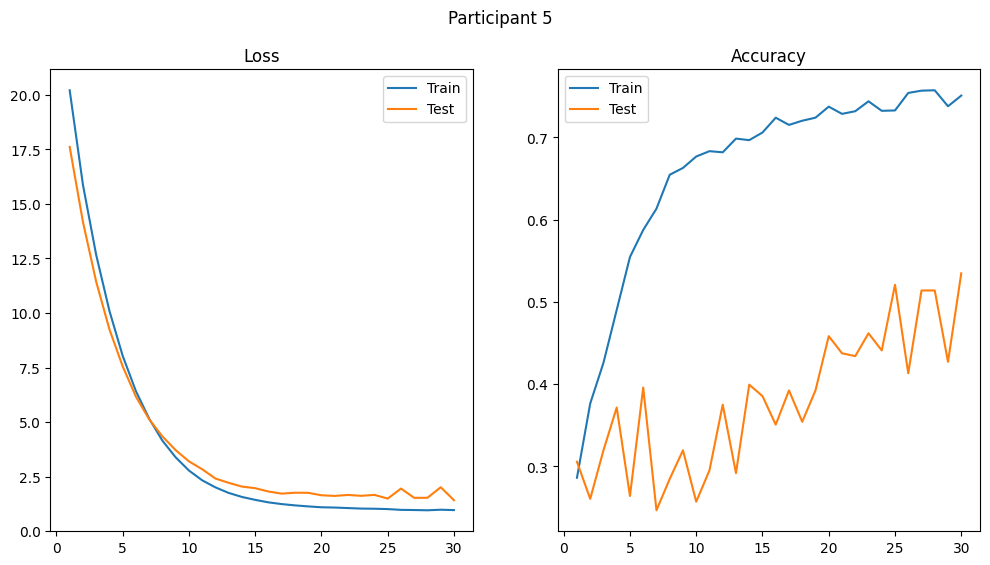

Outer Loop 2 

      Train epochs' shape:                                (2160, 1, 22, 1000)
      Test epochs' shape:                                 (288, 1, 22, 1000)
      Test labels' shape:                                 (288, 4)
      Train labels' shape (without encoding):             (2160, 1)
      Test labels' shape (without encoding):              (288, 1)
      Train index:                                        [1, 3, 4, 5, 6, 7, 8, 9]
      Test index:                                         [2]



Epoch 1/500
34/34 [==============================] - 12s 100ms/step - loss: 19.8246 - accuracy: 0.2917 - val_loss: 17.2596 - val_accuracy: 0.2569
Epoch 2/500
34/34 [==============================] - 2s 61ms/step - loss: 15.4996 - accuracy: 0.3949 - val_loss: 13.8780 - val_accuracy: 0.2951
Epoch 3/500
34/34 [==============================] - 2s 65ms/step - loss: 12.3331 - accuracy: 0.4722 - val_loss: 11.1857 - val_accuracy: 0.3160
Epoch 4/500
34/34 [===========================

<Figure size 640x480 with 0 Axes>

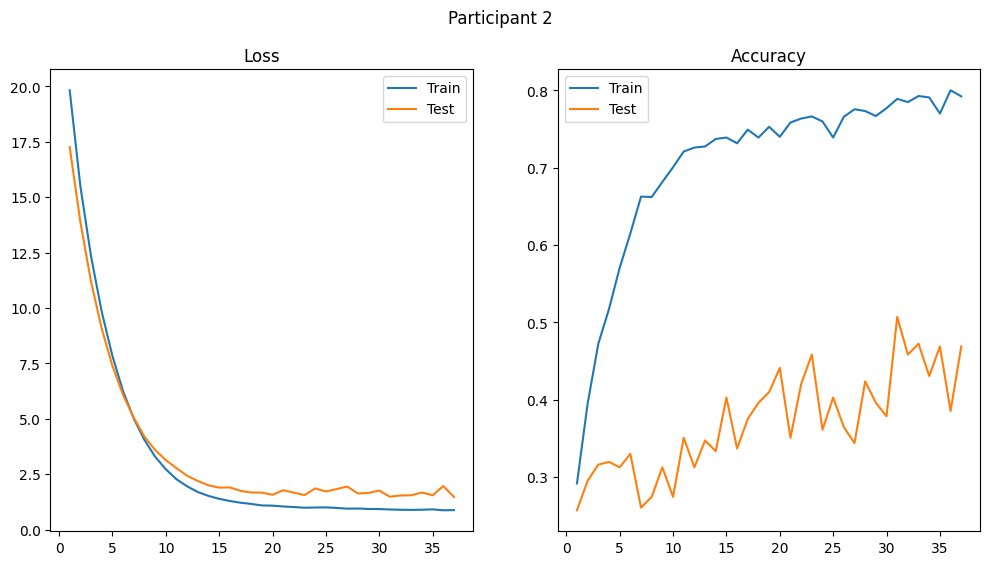

Outer Loop 3 

      Train epochs' shape:                                (2160, 1, 22, 1000)
      Test epochs' shape:                                 (288, 1, 22, 1000)
      Test labels' shape:                                 (288, 4)
      Train labels' shape (without encoding):             (2160, 1)
      Test labels' shape (without encoding):              (288, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 8, 9]
      Test index:                                         [7]



Epoch 1/500
34/34 [==============================] - 12s 100ms/step - loss: 20.4640 - accuracy: 0.3116 - val_loss: 17.8384 - val_accuracy: 0.3125
Epoch 2/500
34/34 [==============================] - 2s 64ms/step - loss: 16.0456 - accuracy: 0.3880 - val_loss: 14.3259 - val_accuracy: 0.3368
Epoch 3/500
34/34 [==============================] - 2s 61ms/step - loss: 12.7667 - accuracy: 0.4620 - val_loss: 11.5102 - val_accuracy: 0.4062
Epoch 4/500
34/34 [===========================

<Figure size 640x480 with 0 Axes>

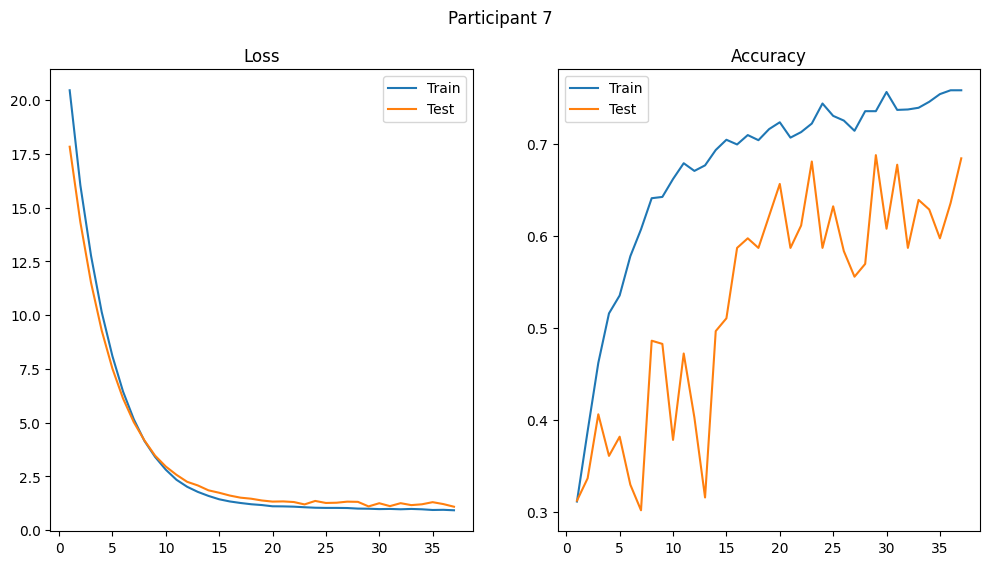

Outer Loop 4 

      Train epochs' shape:                                (2160, 1, 22, 1000)
      Test epochs' shape:                                 (288, 1, 22, 1000)
      Test labels' shape:                                 (288, 4)
      Train labels' shape (without encoding):             (2160, 1)
      Test labels' shape (without encoding):              (288, 1)
      Train index:                                        [1, 2, 4, 5, 6, 7, 8, 9]
      Test index:                                         [3]



Epoch 1/500
34/34 [==============================] - 12s 99ms/step - loss: 20.0544 - accuracy: 0.2940 - val_loss: 17.4583 - val_accuracy: 0.2812
Epoch 2/500
34/34 [==============================] - 2s 62ms/step - loss: 15.6852 - accuracy: 0.4157 - val_loss: 14.0668 - val_accuracy: 0.3021
Epoch 3/500
34/34 [==============================] - 2s 67ms/step - loss: 12.5258 - accuracy: 0.4546 - val_loss: 11.3667 - val_accuracy: 0.2535
Epoch 4/500
34/34 [============================

<Figure size 640x480 with 0 Axes>

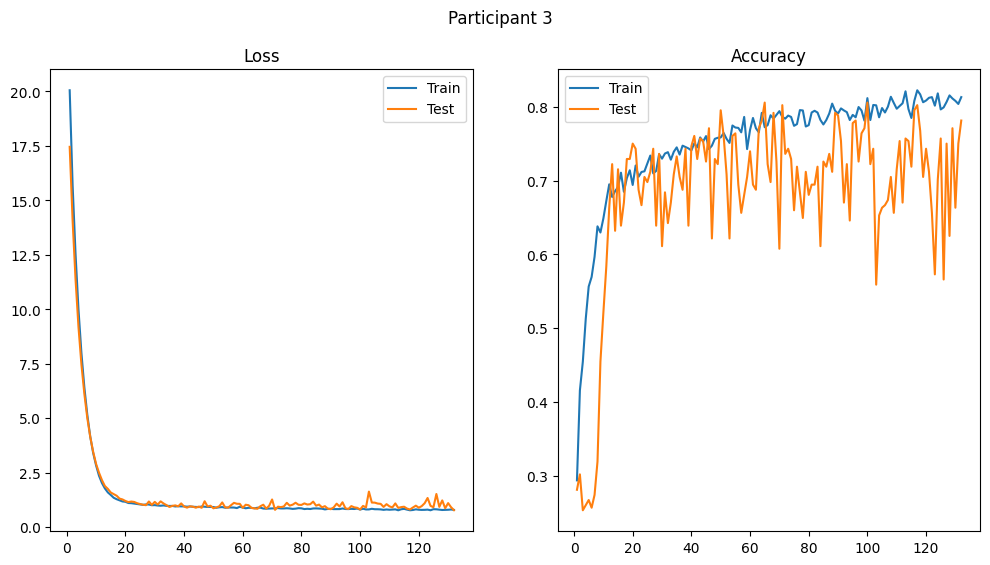

Outer Loop 5 

      Train epochs' shape:                                (2304, 1, 22, 1000)
      Test epochs' shape:                                 (144, 1, 22, 1000)
      Test labels' shape:                                 (144, 4)
      Train labels' shape (without encoding):             (2304, 1)
      Test labels' shape (without encoding):              (144, 1)
      Train index:                                        [1, 2, 3, 5, 6, 7, 8, 9]
      Test index:                                         [4]



Epoch 1/500
36/36 [==============================] - 11s 91ms/step - loss: 19.6839 - accuracy: 0.3190 - val_loss: 17.0104 - val_accuracy: 0.3403
Epoch 2/500
36/36 [==============================] - 2s 59ms/step - loss: 15.2468 - accuracy: 0.3867 - val_loss: 13.4272 - val_accuracy: 0.5069
Epoch 3/500
36/36 [==============================] - 2s 57ms/step - loss: 11.9616 - accuracy: 0.4779 - val_loss: 10.6611 - val_accuracy: 0.4028
Epoch 4/500
36/36 [============================

<Figure size 640x480 with 0 Axes>

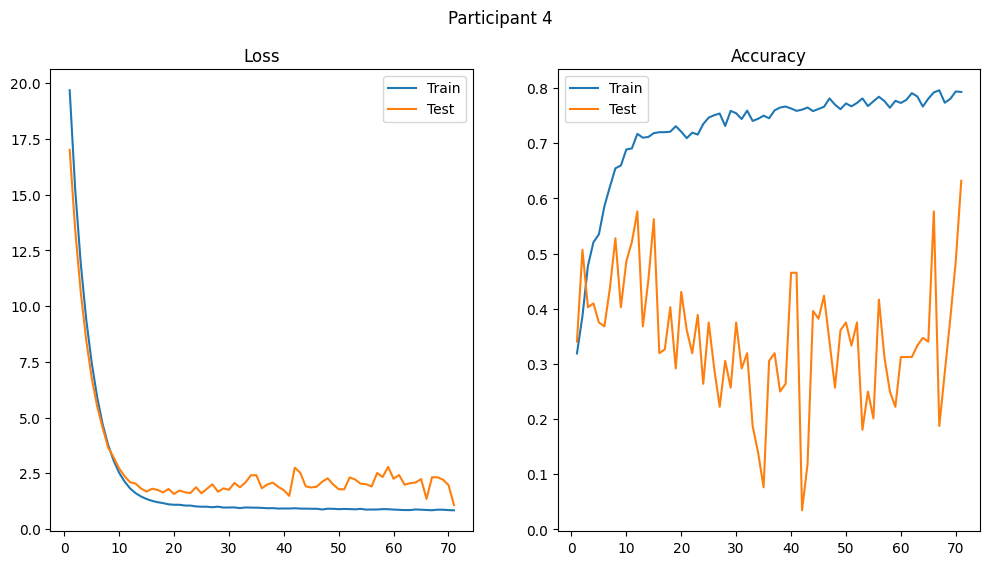

Outer Loop 6 

      Train epochs' shape:                                (2160, 1, 22, 1000)
      Test epochs' shape:                                 (288, 1, 22, 1000)
      Test labels' shape:                                 (288, 4)
      Train labels' shape (without encoding):             (2160, 1)
      Test labels' shape (without encoding):              (288, 1)
      Train index:                                        [2, 3, 4, 5, 6, 7, 8, 9]
      Test index:                                         [1]



Epoch 1/500
34/34 [==============================] - 12s 102ms/step - loss: 20.3896 - accuracy: 0.3213 - val_loss: 17.8079 - val_accuracy: 0.3021
Epoch 2/500
34/34 [==============================] - 2s 65ms/step - loss: 15.9570 - accuracy: 0.4218 - val_loss: 14.3411 - val_accuracy: 0.3160
Epoch 3/500
34/34 [==============================] - 2s 64ms/step - loss: 12.7417 - accuracy: 0.4926 - val_loss: 11.5650 - val_accuracy: 0.3229
Epoch 4/500
34/34 [===========================

<Figure size 640x480 with 0 Axes>

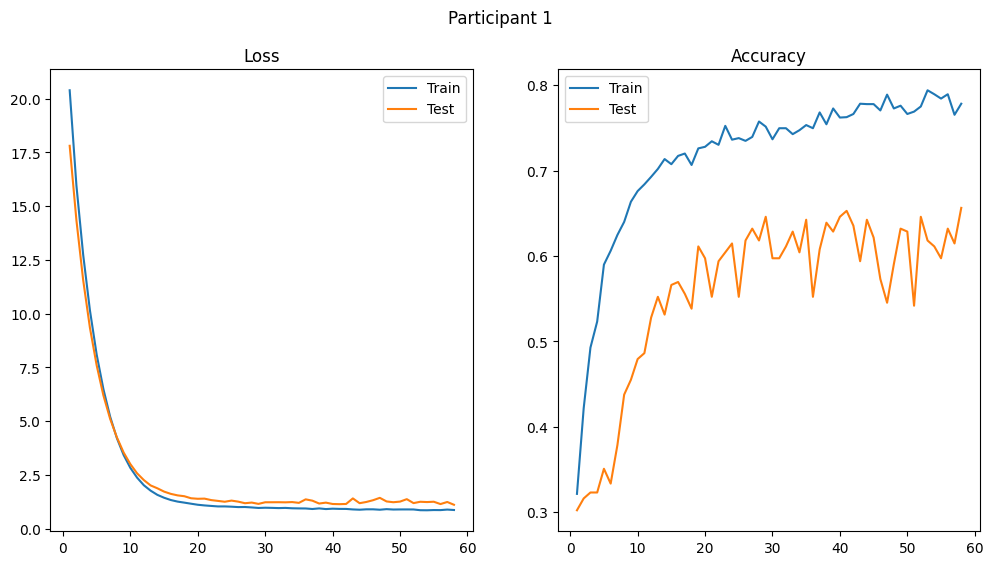

Outer Loop 7 

      Train epochs' shape:                                (2160, 1, 22, 1000)
      Test epochs' shape:                                 (288, 1, 22, 1000)
      Test labels' shape:                                 (288, 4)
      Train labels' shape (without encoding):             (2160, 1)
      Test labels' shape (without encoding):              (288, 1)
      Train index:                                        [1, 2, 3, 4, 5, 7, 8, 9]
      Test index:                                         [6]



Epoch 1/500
34/34 [==============================] - 12s 93ms/step - loss: 20.1174 - accuracy: 0.2981 - val_loss: 17.5159 - val_accuracy: 0.2708
Epoch 2/500
34/34 [==============================] - 2s 63ms/step - loss: 15.7203 - accuracy: 0.3903 - val_loss: 14.0361 - val_accuracy: 0.2604
Epoch 3/500
34/34 [==============================] - 2s 60ms/step - loss: 12.4963 - accuracy: 0.4583 - val_loss: 11.2688 - val_accuracy: 0.2639
Epoch 4/500
34/34 [============================

<Figure size 640x480 with 0 Axes>

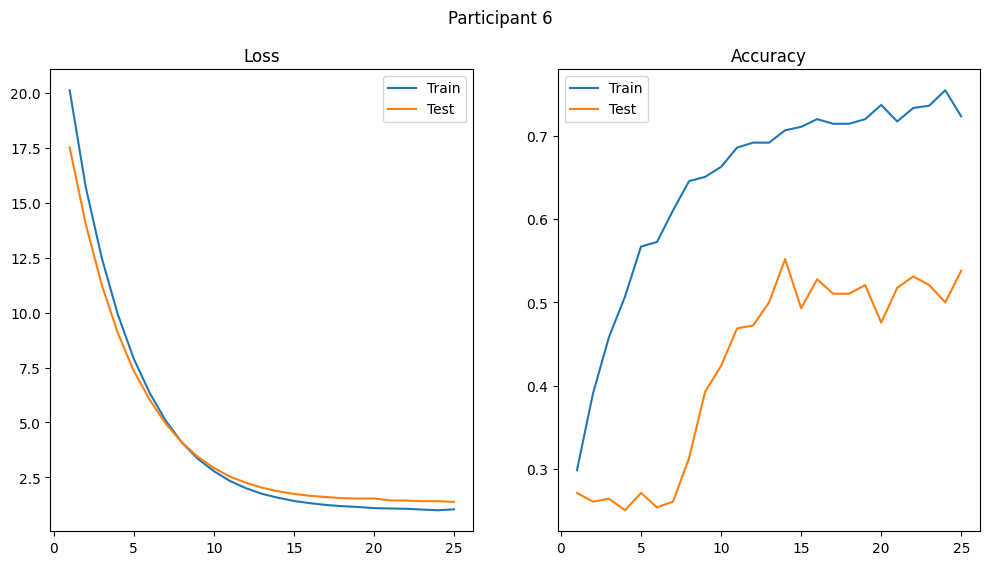

Outer Loop 8 

      Train epochs' shape:                                (2160, 1, 22, 1000)
      Test epochs' shape:                                 (288, 1, 22, 1000)
      Test labels' shape:                                 (288, 4)
      Train labels' shape (without encoding):             (2160, 1)
      Test labels' shape (without encoding):              (288, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 9]
      Test index:                                         [8]



Epoch 1/500
34/34 [==============================] - 12s 100ms/step - loss: 19.6304 - accuracy: 0.2935 - val_loss: 17.0600 - val_accuracy: 0.3125
Epoch 2/500
34/34 [==============================] - 2s 64ms/step - loss: 15.3140 - accuracy: 0.3764 - val_loss: 13.6617 - val_accuracy: 0.3785
Epoch 3/500
34/34 [==============================] - 2s 64ms/step - loss: 12.1443 - accuracy: 0.4593 - val_loss: 10.9720 - val_accuracy: 0.3958
Epoch 4/500
34/34 [===========================

<Figure size 640x480 with 0 Axes>

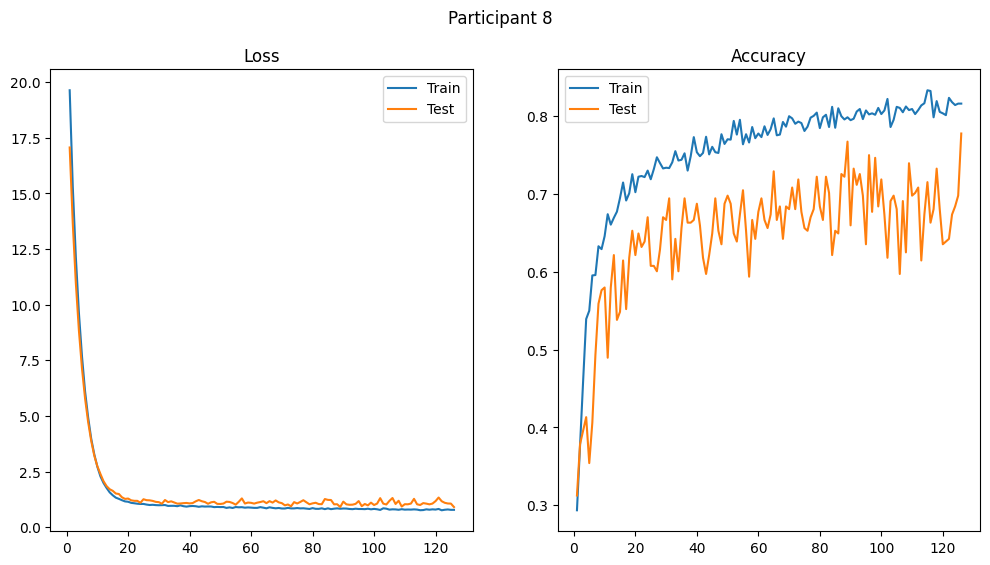

Outer Loop 9 

      Train epochs' shape:                                (2160, 1, 22, 1000)
      Test epochs' shape:                                 (288, 1, 22, 1000)
      Test labels' shape:                                 (288, 4)
      Train labels' shape (without encoding):             (2160, 1)
      Test labels' shape (without encoding):              (288, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8]
      Test index:                                         [9]



Epoch 1/500
34/34 [==============================] - 12s 95ms/step - loss: 19.7207 - accuracy: 0.2931 - val_loss: 17.1552 - val_accuracy: 0.3264
Epoch 2/500
34/34 [==============================] - 2s 66ms/step - loss: 15.4889 - accuracy: 0.3542 - val_loss: 13.7900 - val_accuracy: 0.2882
Epoch 3/500
34/34 [==============================] - 2s 59ms/step - loss: 12.3197 - accuracy: 0.4370 - val_loss: 11.0987 - val_accuracy: 0.2708
Epoch 4/500
34/34 [============================

<Figure size 640x480 with 0 Axes>

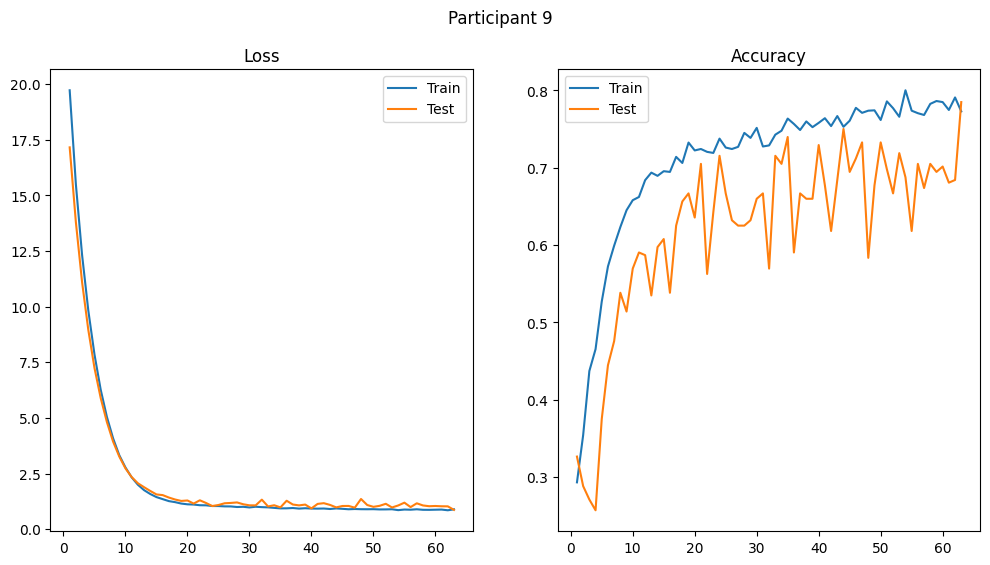

<Figure size 640x480 with 0 Axes>

In [26]:
participants = [1, 2, 3, 4, 5, 6, 7, 8, 9]
class_numbers=4
num_subjects = len(all_data_epochs)
all_tests_true = []
all_tests_pred = []
max_epochs = 500
learning_rate=0.0001



kf_outer2 = KFold(n_splits=num_subjects, shuffle=True, random_state=2)    # Split the data into Train_CrossVal and test sets.



for i, (train_index, test_index) in enumerate(kf_outer2.split(all_data_epochs)):
    
    
    
    train_epochs = np.concatenate([all_data_epochs[j] for j in train_index])
    test_epochs = np.concatenate([all_data_epochs[k] for k in test_index])
    train_labels = np.concatenate([encoded[l] for l in train_index])
    test_labels = np.concatenate([encoded[m] for m in test_index])
    no_encoded_train_labels = np.concatenate([no_encode[n] for n in train_index])
    no_encoded_test_labels = np.concatenate([no_encode[o] for o in test_index])
    train_ids_for_save = [participants[i] for i in train_index]
    test_ids_for_save = [participants[i] for i in test_index]
    
    
    print("Outer Loop {}".format(i+1), "\n")
    print("      Train epochs' shape:                               ", train_epochs.shape)

    print("      Test epochs' shape:                                ", test_epochs.shape)
    print("      Test labels' shape:                                ", test_labels.shape)
    print("      Train labels' shape (without encoding):            ", no_encoded_train_labels.shape)

    print("      Test labels' shape (without encoding):             ", no_encoded_test_labels.shape)
    print("      Train index:                                       ", train_ids_for_save)

    print("      Test index:                                        ", test_ids_for_save)
    print('\n\n')
    
    
    dataset = 'BCI2a'
    in_samples = 1000                   # Changed!!!
    n_channels = 22
    n_sub = 9
    n_classes = 4
    classes_labels = ['Left hand', 'Right hand','Foot','Tongue']
    
    
    # Set dataset paramters as dataset configuration
    dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels,
                    'n_sub': n_sub, 'n_channels': n_channels, 'in_samples': in_samples,
                    'isStandard': True, 'LOSO': True}


    # Set training hyperparamters as train configuration
    train_conf = { 'batch_size': 64, 'epochs': 1000, 'patience': 300, 'lr': 0.001,
                  'LearnCurves': True, 'n_train': 10, 'model':'ATCNet'}

    model = getModel(train_conf.get('model'), dataset_conf)
    

    model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=train_conf.get('lr')), metrics=['accuracy'])  
    
    
    patience = 100
    train_loss_epochs = []
    train_acc_epochs = []
    test_loss_epochs = []
    test_acc_epochs = []
    train_conf_mat = []
    
    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    
#     # Normalizing the features
#     mean = train_epochs.mean(axis=(0, 2, 3), keepdims=True)
#     std = train_epochs.std(axis=(0, 2, 3), keepdims=True)
    
#     print(mean.shape)
#     print(std.shape)
    
#     norm_train_epochs = (train_epochs - mean) / std
#     norm_test_epochs = (test_epochs - mean) / std
    
    
    
    
    # Train the model
    history = model.fit(
        train_epochs, train_labels,
        validation_data=(test_epochs, test_labels),
        epochs=max_epochs,
        batch_size=64,  # Adjust as needed
        callbacks=[early_stopping]
    )
    
    y_pred_test = model.predict(test_epochs)
    y_true_test = test_labels
    
    with open("y_pred_testID_{}.pickle".format(participants[test_index[0]]), 'wb') as f:
        pickle.dump(y_pred_test, f)
    
    with open("y_true_testID_{}.pickle".format(participants[test_index[0]]), 'wb') as f:
        pickle.dump(y_true_test, f)
    
    # Collect training metrics
    train_loss_epochs.extend(history.history['loss'])
    train_acc_epochs.extend(history.history['accuracy'])

    # Collect testing metrics
    test_loss_epochs.extend(history.history['val_loss'])
    test_acc_epochs.extend(history.history['val_accuracy'])
    
    epochs_range = np.arange(1, len(train_loss_epochs[:-1*patience])+1)
    
    plt.figure(figsize=(12, 6))
    plt.suptitle("Participant {}".format(participants[test_index[0]]))

    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(epochs_range, train_loss_epochs[:-1*patience])
    plt.plot(epochs_range, test_loss_epochs[:-1*patience])
    plt.legend(["Train", "Test"])

    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(epochs_range, train_acc_epochs[:-1*patience])
    plt.plot(epochs_range, test_acc_epochs[:-1*patience])
    plt.legend(["Train", "Test"])
    plt.savefig("P{}.jpg".format(participants[test_index[0]]))
    plt.show()
    plt.clf()

In [27]:
confusion_matrices = []
all_y_pred = []
all_y_true = []

for i in range(1, 10):
    with open("y_pred_testID_{}.pickle".format(i), 'rb') as f:
        all_y_pred.append(pickle.load(f))
        
        
    with open("y_true_testID_{}.pickle".format(i), 'rb') as f:
        all_y_true.append(pickle.load(f))
        
    y_true = all_y_true[i-1]
    y_pred = all_y_pred[i-1]
    y_true = y_true.argmax(axis=1)
    y_pred = y_pred.argmax(axis=1)
    confusion_matrices.append(confusion_matrix(y_true, y_pred))

In [28]:
len(confusion_matrices)

9

In [29]:
summation = pd.DataFrame(sum(confusion_matrices), index=['Left (True)', 'Right (True)', 'Feet (True)', 'Tongue (True)'], columns=['Left (Pred)', 'Right (Pred)', 'Feet (Pred)', 'Tongue (Pred)'])
normalized = summation.div(summation.sum(axis=1), axis=0)
acc = normalized.values.trace() / 4


In [30]:
summation.sum(axis=1)

Left (True)      648
Right (True)     648
Feet (True)      576
Tongue (True)    576
dtype: int64

In [68]:
acc

0.6418306327160493

In [31]:
print("Dataset: BCI-IV 2a")
print("The cross-subject scenario:")
print("Algorithm: ATCNet")
print("Accuracy: ", acc)

normalized

Dataset: BCI-IV 2a
The cross-subject scenario:
Algorithm: ATCNet
Accuracy:  0.6489197530864198


,Left (Pred),Right (Pred),Feet (Pred),Tongue (Pred)
Left (True),0.750000,0.108025,0.091049,0.050926
Right (True),0.154321,0.651235,0.089506,0.104938
Feet (True),0.187500,0.156250,0.579861,0.076389
Tongue (True),0.137153,0.161458,0.086806,0.614583


In [72]:
np.argmax([1, 1, 2, 2, 3, 3, 3, 1])

4

# Test for the effect of calibration:

In [32]:
models = []
Calibrated_model = []
for file in os.listdir("/home/bijan/py3x"):
    if file.endswith(".h5") and file.startswith("Calibrated"):
        Calibrated_model.append(file)
    elif file.endswith(".h5") and file.startswith("Model"):
        models.append(file)
        
Calibrated_model = sorted(Calibrated_model)
models = sorted(models)

In [49]:
models = {}
Calibrated_models = {}
for i in range(14):
    if i == 8:
        continue
        
    for j in range(6):
        #print("Model{}{}.h5".format(i+1, j+1))
        model_name = "Model{}{}.h5".format(i+1, j+1)
        Calibrated_model_name = "Calibrated_Model{}{}.h5".format(i+1, j+1)
        models["{:02}{:02}".format(i+1, j+1)] = load_model(model_name)
        Calibrated_models["{:02}{:02}".format(i+1, j+1)] = load_model(Calibrated_model_name)

In [50]:
"{:02}{:02}".format(2, 3)

'0203'

In [51]:
models["1406"].summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_251 (Dense)           (None, 36)                20772     
                                                                 
 dense_252 (Dense)           (None, 4)                 148       
                                                                 
 dense_253 (Dense)           (None, 2)                 10        
                                                                 
Total params: 20,930
Trainable params: 20,930
Non-trainable params: 0
_________________________________________________________________


In [52]:
Calibrated_models["1406"].summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_251 (Dense)           (None, 36)                20772     
                                                                 
 dense_252 (Dense)           (None, 4)                 148       
                                                                 
 dense_253 (Dense)           (None, 2)                 10        
                                                                 
Total params: 20,930
Trainable params: 20,930
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_subjects = len(EEG_epochs)
all_tests_true = []
all_tests_pred = []
models = {}
Calibrated_models = {}

kf_outer1 = KFold(n_splits=6, shuffle=True, random_state=42)              # Split the data into Train and Cross-Validation sets
kf_outer2 = KFold(n_splits=num_subjects, shuffle=True, random_state=2)    # Split the data into Train_CrossVal and test sets.


for i, (train_crossval_index, test_index) in enumerate(kf_outer2.split(EEG_epochs)):
    
    if test_index == 7:
        continue
    
    train_crossval = [EEG_epochs[i] for i in train_crossval_index]
    test_epochs = np.concatenate([EEG_epochs[i] for i in test_index])
    train_crossval_labels = [encoded[i] for i in train_crossval_index]
    test_labels = np.concatenate([encoded[i] for i in test_index])
    no_encoded_train_crossval = [no_encode[i] for i in train_crossval_index]
    no_encoded_test = np.concatenate([no_encode[i] for i in test_index])

    temp_pred = []
    temp_true = []

    for j, (train_index, val_index) in enumerate(kf_outer1.split(train_crossval)):
        
        
        train_epochs = np.concatenate([train_crossval[i] for i in train_index])
        crossval_epochs = np.concatenate([train_crossval[i] for i in val_index])
        train_labels = np.concatenate([train_crossval_labels[i] for i in train_index])
        crossval_labels = np.concatenate([train_crossval_labels[i] for i in val_index])
        no_encoded_train = np.concatenate([no_encoded_train_crossval[i] for i in train_index])
        no_encoded_crossval = np.concatenate([no_encoded_train_crossval[i] for i in val_index])
        train_ids_for_save = [train_crossval_index[i] for i in train_index]
        cross_val_ids_for_save = [train_crossval_index[i] for i in val_index]
        
        
        print("Outer Loop {} and Inner Loop {}:".format(i+1, j+1), "\n")
        print("      Train epochs' shape:                               ", train_epochs.shape)
        #print("     Train labels' shape:                               ", train_labels.shape)
        print("      Cross-validation epochs' shape:                    ", crossval_epochs.shape)
        #print("     Cross-validation labels' shape:                    ", crossval_labels.shape)
        print("      Test epochs' shape:                                ", test_epochs.shape)
        #print("     Test labels' shape:                                ", test_labels.shape)
        #print("     Train labels' shape (without encoding):            ", no_encoded_train.shape)
        #print("     Cross-validation labels' shape (without encoding): ", no_encoded_crossval.shape)
        #print("     Test labels' shape (without encoding):             ", no_encoded_test.shape)
        print("      Train index:                                      ", train_ids_for_save)
        print("      Cross-validation index:                           ", cross_val_ids_for_save)
        print("      Test index:                                       ", test_index)
        print('\n\n')
        
        original_stdout = sys.stdout
        sys.stdout = open('temp_stdout{}.txt'.format(i), 'w')  # Redirect output to a temporary file
        train_features, CrossVal_features, test_features = feature_extraction_cv(train_epochs, no_encoded_train, crossval_epochs, test_epochs, number_of_bands=9, sampling_freq=250, low_cutoff=0, number_of_components=64)
        sys.stdout.close()
        sys.stdout = original_stdout
    
        print("Train features shape:            ", train_features.shape)
        print("Cross-validation features shape: ", CrossVal_features.shape)
        print("Test features shape:             ", test_features.shape)
    
        model_name = "Model{}{}.h5".format(i+1, j+1)
        Calibrated_model_name = "Calibrated_Model{}{}.h5".format(i+1, j+1)
        models["{:02}{:02}".format(i+1, j+1)] = load_model(model_name)
        Calibrated_models["{:02}{:02}".format(i+1, j+1)] = load_model(Calibrated_model_name)
        
        temp_pred.append(models["{:02}{:02}".format(i+1, j+1)].predict(test_features[60:]))
        temp_true.append(test_labels[60:])
        
    all_tests_pred.append(temp_pred)
    all_tests_true.append(temp_true)
    


Outer Loop 1 and Inner Loop 1: 

      Train epochs' shape:                                (1337, 64, 1123)
      Cross-validation epochs' shape:                     (420, 64, 1123)
      Test epochs' shape:                                 (140, 64, 1123)
      Train index:                                       [1, 2, 3, 4, 5, 6, 7, 8, 10, 13]
      Cross-validation index:                            [0, 9, 12]
      Test index:                                        [11]



Train features shape:             (1337, 576)
Cross-validation features shape:  (420, 576)
Test features shape:              (140, 576)
Outer Loop 1 and Inner Loop 2: 

      Train epochs' shape:                                (1477, 64, 1123)
      Cross-validation epochs' shape:                     (280, 64, 1123)
      Test epochs' shape:                                 (140, 64, 1123)
      Train index:                                       [0, 1, 2, 3, 4, 6, 7, 9, 10, 12, 13]
      Cross-validation index:      

In [26]:
import pickle
with open("all_tests_pred_without_calibration", "wb") as fp:
    pickle.dump(all_tests_pred, fp)

with open("all_tests_true_without_calibration", "wb") as fp:
    pickle.dump(all_tests_true, fp)

In [27]:
confusion_matrices_ap = []
for i in range(len(all_tests_pred)):
    for j in range(len(all_tests_pred[1])):
        y_true = 2 - np.argmax(all_tests_true[i][j], axis=1)
        y_pred = 2 - np.argmax(all_tests_pred[i][j], axis=1)
    confusion_matrices_ap.append(confusion_matrix(y_true, y_pred))

In [28]:
summation = pd.DataFrame(sum(confusion_matrices_ap), index=['class 1 (True)', 'class 2 (True)'], columns=['class 1 (Pred)', 'class 2 (Pred)'])
summation

,class 1 (Pred),class 2 (Pred)
class 1 (True),358,162
class 2 (True),202,315


In [31]:
summation / 520

,class 1 (Pred),class 2 (Pred)
class 1 (True),0.688462,0.311538
class 2 (True),0.388462,0.605769


In [29]:
mean_confusion_matrix = sum(confusion_matrices_ap) / len(confusion_matrices_ap)

true_positive = mean_confusion_matrix[1, 1]
true_negative = mean_confusion_matrix[0, 0]
false_positive = mean_confusion_matrix[0, 1]
false_negative = mean_confusion_matrix[1, 0]
 
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
sensitivity = recall  # Same as recall
f1 = 2 * (precision * recall) / (precision + recall)

print("Average metrics for binary classification (Left vs Right hand):\n\n")
print(f"       Accuracy:                  {accuracy:.2f}\n")
print(f"       Precision:                 {precision:.2f}\n")
print(f"       Recall (Sensitivity):      {recall:.2f}     \n")
print(f"       F1 Score:                  {f1:.2f}\n")


Average metrics for binary classification (Left vs Right hand):


       Accuracy:                  0.65

       Precision:                 0.66

       Recall (Sensitivity):      0.61     

       F1 Score:                  0.63



# Test of the functions:

In [37]:
a = np.random.rand(200, 4, 22, 250)
b = np.random.randint(0, 3, (200, 1))
c = np.random.rand(50, 4, 22, 250)

In [ ]:
train_features, test_features = feature_extraction_4(a, b, c, sampling_freq=250)

In [43]:
train_features.shape

(800, 80)

In [45]:
test_features.shape

(200, 80)

# Filter validation:

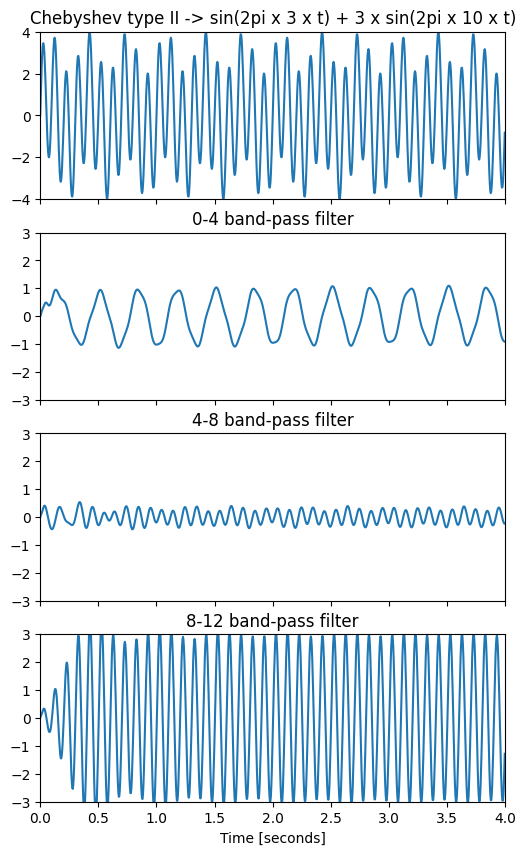

In [85]:
t = np.linspace(0, 4, 1000, False)  # 4 second
sig = np.sin(2*np.pi*3*t) + 3 * np.sin(2*np.pi*10*t)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(6, 10))
ax1.plot(t, sig)
ax1.set_title('Chebyshev type II -> sin(2pi x 3 x t) + 3 x sin(2pi x 10 x t)')
ax1.axis([0, 1, -4, 4])

sos1 = signal.cheby2(15, 20, [0.1, 4], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos1, sig)
ax2.plot(t, filtered)
ax2.set_title('0-4 band-pass filter')
ax2.axis([0, 4, -3, 3])

sos2 = signal.cheby2(10, 20, [4, 8], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos2, sig)
ax3.plot(t, filtered)
ax3.set_title('4-8 band-pass filter')
ax3.axis([0, 4, -3, 3])

sos3 = signal.cheby2(10, 20, [8, 12], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos3, sig)
ax4.plot(t, filtered)
ax4.set_title('8-12 band-pass filter')
ax4.axis([0, 4, -3, 3])
ax4.set_xlabel('Time [seconds]')

plt.show()

Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 413 samples (1.652 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 413 samples (1.652 s)

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
--------------

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


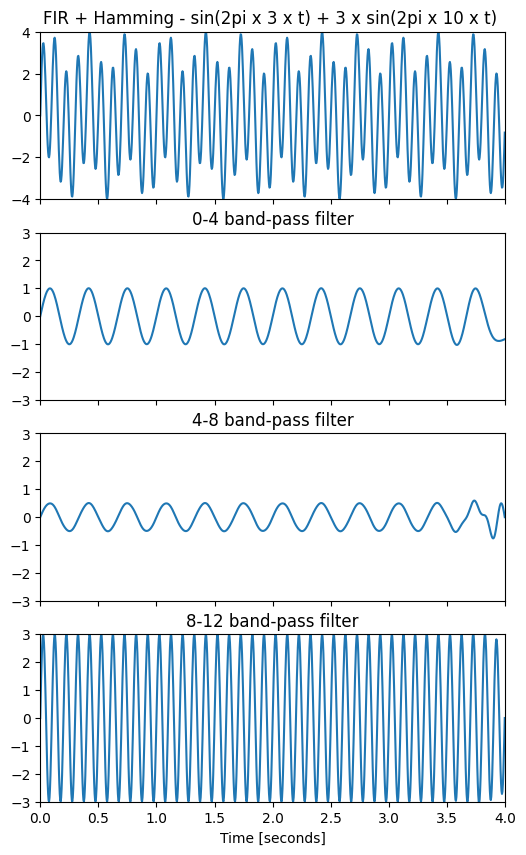

In [86]:
t = np.linspace(0, 4, 1000, False)  # 4 second
sig = np.sin(2*np.pi*3*t) + 3 * np.sin(2*np.pi*10*t)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(6, 10))
ax1.plot(t, sig)
ax1.set_title('FIR + Hamming - sin(2pi x 3 x t) + 3 x sin(2pi x 10 x t) ')
ax1.axis([0, 1, -4, 4])


filtered = mne.filter.filter_data(sig, 250, 0, 4)
ax2.plot(t, filtered)
ax2.set_title('0-4 band-pass filter')
ax2.axis([0, 4, -3, 3])

filtered = mne.filter.filter_data(sig, 250, 4, 8)
ax3.plot(t, filtered)
ax3.set_title('4-8 band-pass filter')
ax3.axis([0, 4, -3, 3])

filtered = mne.filter.filter_data(sig, 250, 8, 12)
ax4.plot(t, filtered)
ax4.set_title('8-12 band-pass filter')
ax4.axis([0, 4, -3, 3])
ax4.set_xlabel('Time [seconds]')

plt.show()

ValueError: x and y must have same first dimension, but have shapes (1000,) and (3, 1000)

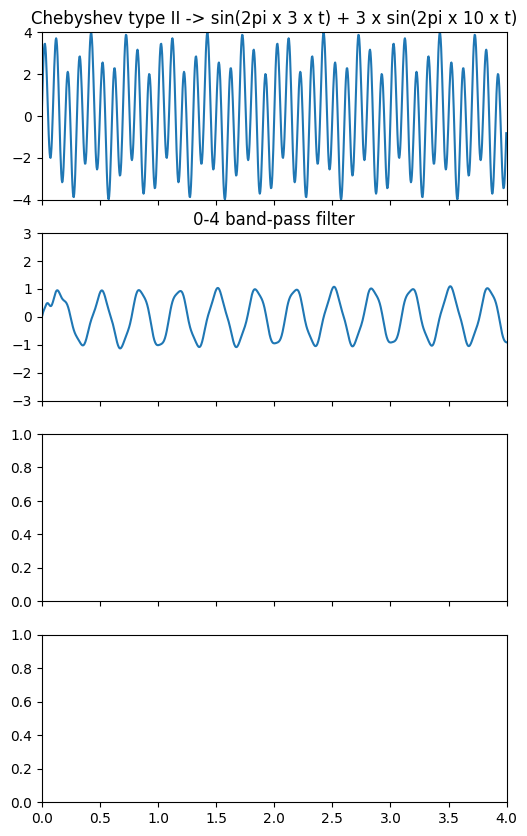

In [29]:
t = np.linspace(0, 4, 1000, False)  # 4 second
sig = np.sin(2*np.pi*3*t) + 3 * np.sin(2*np.pi*10*t)

sig = np.tile(sig, (3, 1))

print(sig.shape)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(6, 10))
ax1.plot(t, sig[0])
ax1.set_title('Chebyshev type II -> sin(2pi x 3 x t) + 3 x sin(2pi x 10 x t)')
ax1.axis([0, 1, -4, 4])

sos1 = signal.cheby2(15, 20, [0.1, 4], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos1, sig)
ax2.plot(t, filtered[0])
ax2.set_title('0-4 band-pass filter')
ax2.axis([0, 4, -3, 3])

sos2 = signal.cheby2(10, 20, [4, 8], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos2, sig)
ax3.plot(t, filtered)
ax3.set_title('4-8 band-pass filter')
ax3.axis([0, 4, -3, 3])

sos3 = signal.cheby2(10, 20, [8, 12], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos3, sig)
ax4.plot(t, filtered)
ax4.set_title('8-12 band-pass filter')
ax4.axis([0, 4, -3, 3])
ax4.set_xlabel('Time [seconds]')

plt.show()

# CSP Validation:

In [199]:
t = np.linspace(0, 5, 1250, False)  # 4 second
sig1 = np.sin(2*np.pi*35*t) + 3 * np.sin(2*np.pi*10*t)
sig2 = np.sin(2*np.pi*100*t) + 3 * np.sin(2*np.pi*50*t)

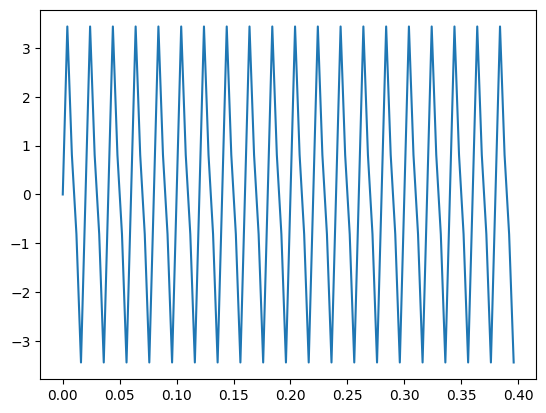

In [200]:
plt.plot(t[:100], sig2[:100])

In [201]:
np.expand_dims(sig1, axis=1)

array([[ 0.        ],
       [ 1.5165829 ],
       [ 2.42754827],
       ...,
       [-2.53539499],
       [-2.42754827],
       [-1.5165829 ]])

In [202]:
sig1 = np.expand_dims(sig1, axis=0)
sig2 = np.expand_dims(sig2, axis=0)
sig1.shape, sig2.shape

((1, 1250), (1, 1250))

In [203]:
sig = np.concatenate((sig1, sig2), axis=0)

In [204]:
sig = np.expand_dims(sig, axis=0)
sig.shape

(1, 2, 1250)

In [205]:
s_epoch = np.tile(sig, (50, 1, 1))
s_epoch.shape, (s_epoch[0, :, :] == s_epoch[10, :, :]).all()

((50, 2, 1250), True)

In [206]:
s_train_epochs = slicer(s_epoch, num_splits=2)

In [207]:
s_train_epochs.shape

(50, 2, 2, 625)

In [208]:
s_no_encoded_train_labels = np.random.randint(0, 3, (50, 1))

In [209]:
mne.set_log_level('warning')
train_feats, test_feats, filtered_data = Preprocess_validator(s_train_epochs, s_no_encoded_train_labels, s_train_epochs, sampling_freq = 250, n_components=2)

The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.011005878448486328
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.011038541793823242
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.010999679565429688
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.011005163192749023
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012004613876342773
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.010001897811889648
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012001514434814453
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012008190155029297
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.009999990463256836
The filtered data shape: (100, 2, 625)
Time taken for csp calculations:  0.012001514434814453
The filtered data shape: (100, 2, 625)
Time taken for csp ca

In [210]:
train_feats.shape

(50, 2, 16, 2)

In [211]:
filtered_data.shape

(50, 2, 2, 625)

In [212]:
(filtered_data[0, :, :, :] == filtered_data[10, :, :, :]).all()

True

In [213]:
(filtered_data[:, :, 0, :] == filtered_data[:, :, 0, :]).all()

True

In [214]:
(filtered_data[:, 0, :, :] == filtered_data[:, 1, :, :]).any()

True

In [215]:
(s_train_epochs[:, 0, :, :] == s_train_epochs[:, 1, :, :]).any()

False

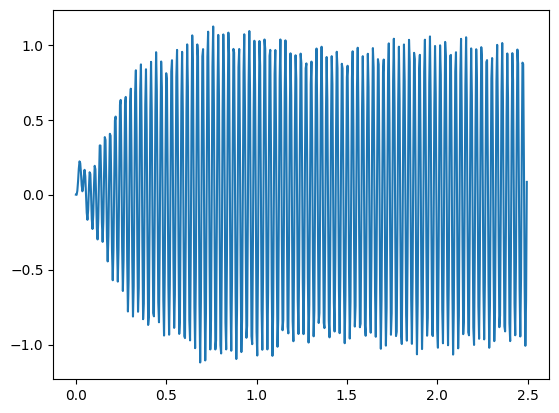

In [216]:
y = filtered_data[0, 1, 0, :]
plt.plot(t[:625], y)

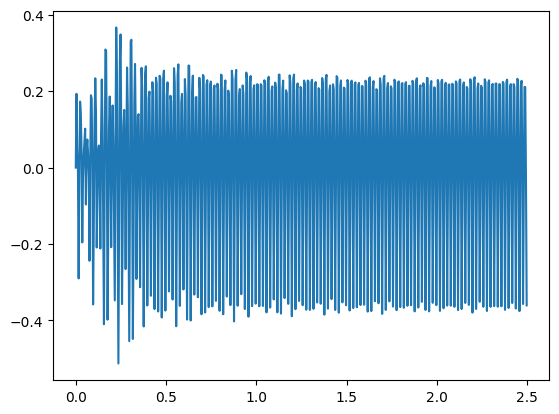

In [217]:
y = filtered_data[0, 0, 1, :]
plt.plot(t[:625], y)

# Heatmap on FBCSP:

In [218]:
with open("train_features_fortestID_[0].pickle", "rb") as f:
    train_features = pickle.load(f)
    f.close()

In [219]:
train_features.shape

(2160, 5, 16, 16)

In [221]:
new_array = np.zeros((2160, 16, 80))

In [222]:
for i in range(5):
    new_array[:, :, 16*i:16*i+16] = train_features[:, i, :, :]
    print((new_array[:, :, 16*i:16*i+16]).shape)

(2160, 16, 16)
(2160, 16, 16)
(2160, 16, 16)
(2160, 16, 16)
(2160, 16, 16)


In [223]:
new_array.shape

(2160, 16, 80)

In [225]:
heat_value = new_array.mean(axis=0)

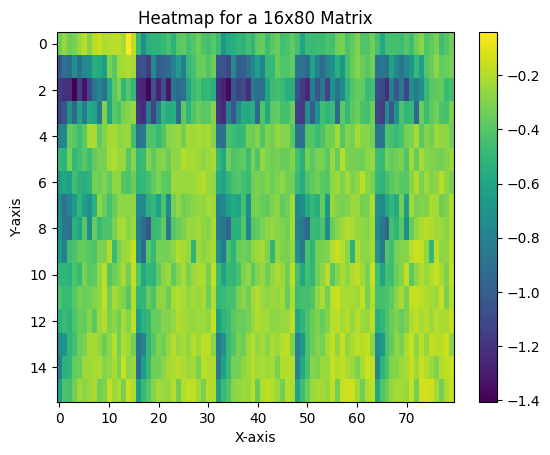

In [226]:
plt.imshow(heat_value, cmap='viridis', aspect='auto')

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Heatmap for a 16x80 Matrix')

# Show the colorbar
plt.colorbar()

# Show the plot
plt.show()

In [29]:
all_epochs = np.concatenate(all_data_epochs)
all_labels = np.concatenate(no_encode)


mne.set_log_level('warning')
all_features, _ = feature_extraction_cheby2(all_epochs, all_labels, all_epochs, sampling_freq = 250, n_components=16)
#sys.stdout.close()
#sys.stdout = original_stdout


print("All epochs features shape:", all_features.shape)


with open("All_data_features.pickle", "wb") as f:
    pickle.dump(all_features, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()


The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.928704977035522
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.971172571182251
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  11.614934921264648
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.451647520065308
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.614197254180908
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  11.34934687614441
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.473000526428223
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.482449293136597
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.383591890335083
The filtered data shape: (12240, 22, 200)
Time taken for csp calculations:  10.589037895202637
The filtered data shape: (12240, 22, 200)
Time take

NameError: name 'train_features' is not defined

In [47]:
new_array = np.zeros((2448, 16, 80))
for i in range(5):
    new_array[:, :, 16*i:16*i+16] = all_features[:, i, :, :]
    print((new_array[:, :, 16*i:16*i+16]).shape)
print("\n\n")
print("new array shape:", new_array.shape)

(2448, 16, 16)
(2448, 16, 16)
(2448, 16, 16)
(2448, 16, 16)
(2448, 16, 16)



new array shape: (2448, 16, 80)


In [30]:
print("All epochs features shape:", all_features.shape)

All epochs features shape: (2448, 5, 16, 16)


In [48]:
epochs_1 = new_array[(all_labels == 0).squeeze(), :, :]
epochs_2 = new_array[(all_labels == 1).squeeze(), :, :]
epochs_3 = new_array[(all_labels == 2).squeeze(), :, :]
epochs_4 = new_array[(all_labels == 3).squeeze(), :, :]


In [49]:
print("Left epochs shape:  ", epochs_1.shape)
print("Right epochs shape: ", epochs_2.shape)
print("Feet epochs shape:  ", epochs_3.shape)
print("Tongue epochs shape:", epochs_4.shape)

Left epochs shape:   (648, 16, 80)
Right epochs shape:  (648, 16, 80)
Feet epochs shape:   (576, 16, 80)
Tongue epochs shape: (576, 16, 80)


In [50]:
epochs_1 = epochs_1.mean(axis=0)
epochs_2 = epochs_2.mean(axis=0)
epochs_3 = epochs_3.mean(axis=0)
epochs_4 = epochs_4.mean(axis=0)

In [62]:
epochs_1

(16, 80)

In [34]:
(all_labels == 0).sum()

648

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 800x1000 with 0 Axes>

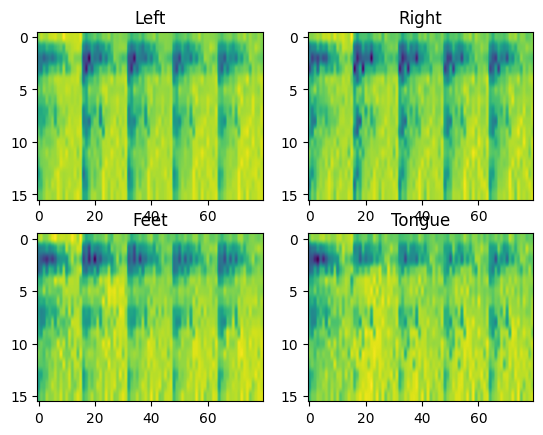

In [59]:
plt.figure(1, (8, 10))
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(epochs_1, cmap='viridis', aspect='auto')
axs[0, 0].set_title("Left")

axs[0, 1].imshow(epochs_2, cmap='viridis', aspect='auto')
axs[0, 1].set_title("Right")

axs[1, 0].imshow(epochs_3, cmap='viridis', aspect='auto')
axs[1, 0].set_title("Feet")

axs[1, 1].imshow(epochs_4, cmap='viridis', aspect='auto')
axs[1, 1].set_title("Tongue")

# Show the colorbar
plt.colorbar()

# Show the plot
plt.show()